In [1]:
%%time

import pandas as pd

train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', nrows=800000)
test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')

CPU times: user 4.22 s, sys: 946 ms, total: 5.17 s
Wall time: 6.96 s


In [2]:
# Fill NaN values: numeric columns with 0 and text columns with 'unknown'
new_train = train.fillna({col: 0 if train[col].dtype in ['int64', 'float64'] else 'unknown' for col in train.columns})
new_test = test.fillna({col: 0 if test[col].dtype in ['int64', 'float64'] else 'unknown' for col in test.columns})

In [3]:
def map_premium(amount):
    if amount < 50:
        return 'Low'
    elif 60 <= amount <= 100:
        return 'Moderate'
    elif amount >= 110:
        return 'High'
    else:
        return 'Undefined'

new_train['Premium Category'] = new_train['Premium Amount'].apply(map_premium)

In [4]:
new_train['Premium Category'] = new_train['Premium Amount'].apply(map_premium)

- Calculate how much percentage bad and good feedback

In [5]:
feedback_counts = new_train['Customer Feedback'].value_counts()
feedback_percentages = (feedback_counts / len(new_train)) * 100
feedback_percentages

Customer Feedback
Average    31.508625
Poor       31.312625
Good       30.697375
unknown     6.481375
Name: count, dtype: float64

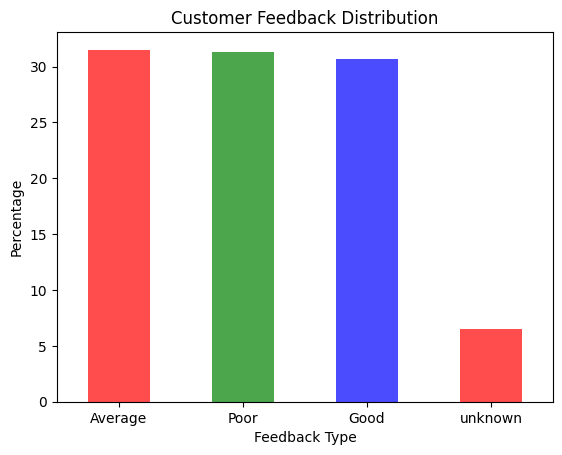

In [6]:
import matplotlib.pyplot as plt

# Visualizing the feedback percentages
feedback_percentages.plot(kind='bar', color=['red', 'green', 'blue'], alpha=0.7)
plt.title('Customer Feedback Distribution')
plt.xlabel('Feedback Type')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

- Calculate how much percentage of each gender

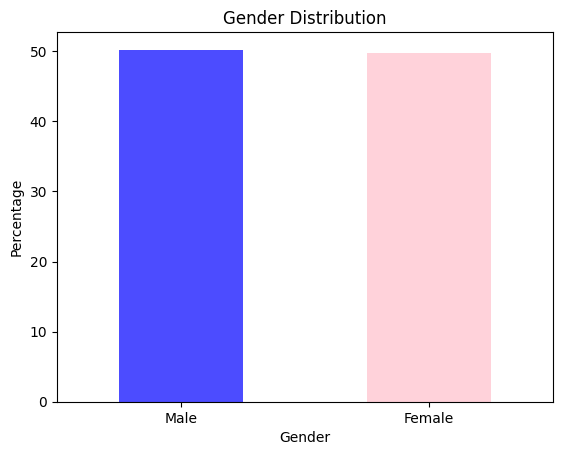

In [7]:
# Calculate the percentage of each gender
gender_counts = new_train['Gender'].value_counts()
gender_percentages = (gender_counts / len(new_train)) * 100

# Visualize the gender percentages
gender_percentages.plot(kind='bar', color=['blue', 'pink'], alpha=0.7)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

- Calculate the percentage of each occupation

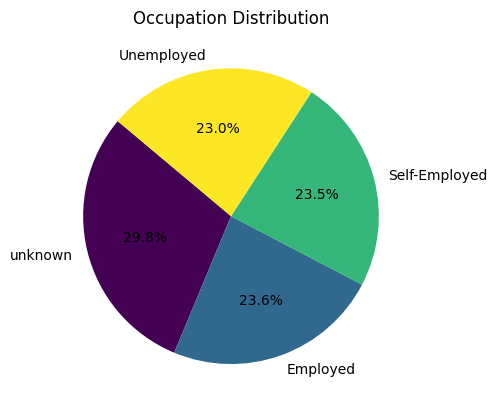

In [8]:
occupation_counts = new_train['Occupation'].value_counts()
occupation_percentages = (occupation_counts / len(new_train)) * 100

# Visualize the occupation percentages
occupation_percentages.plot(kind='pie', autopct='%1.1f%%', startangle=140, colormap='viridis')
plt.title('Occupation Distribution')
plt.ylabel('')
plt.show()

- Calculate the total claims and total premiums earned

In [9]:
total_claims = new_train['Previous Claims'].sum()
total_premiums_earned = new_train['Premium Amount'].sum()

# Calculate the profitability ratio
profitability_ratio = total_claims / total_premiums_earned
profitability_ratio

0.0006332831496929769

- Calculate the number of claims (non-null values in 'Previous Claims')

In [10]:
number_of_claims = new_train['Previous Claims'].count()

# Calculate the average cost of claims incurred
average_claim_cost = total_claims / number_of_claims
average_claim_cost

0.69799375

- Extracting the year from the Policy Start Date to identify renewals

In [11]:
new_train['Policy Start Year'] = pd.to_datetime(new_train['Policy Start Date']).dt.year

# Assuming policies come up for renewal if they started in the previous year
current_year = pd.Timestamp.now().year
renewal_candidates = new_train[new_train['Policy Start Year'] == current_year - 1]

# Assuming customers who renewed have a non-null value in 'Insurance Duration'
renewed_customers = renewal_candidates[renewal_candidates['Insurance Duration'].notnull()]

# Calculate the percentage of customers who renewed their policies
renewal_percentage = (len(renewed_customers) / len(renewal_candidates)) * 100 if len(renewal_candidates) > 0 else 0
renewal_percentage

100.0

- Calculate the total revenue expected from a customer over their entire relationship with the insurer

In [12]:
# Assuming total revenue is the product of Premium Amount and Insurance Duration
new_train['Total Revenue'] = new_train['Premium Amount'] * new_train['Insurance Duration']

# Total Revenue column
new_train[['id', 'Total Revenue']].head()

,id,Total Revenue
0,0,14345.0
1,1,2966.0
2,2,1701.0
3,3,765.0
4,4,8088.0


- Calculate the growth rate of premiums written over time

In [13]:
# Convert Policy Start Date to datetime format
new_train['Policy Start Date'] = pd.to_datetime(new_train['Policy Start Date'])

# Extract the year from Policy Start Date
new_train['Policy Year'] = new_train['Policy Start Date'].dt.year

# Calculate total premiums written per year
premiums_per_year = new_train.groupby('Policy Year')['Premium Amount'].sum()

# Calculate the growth rate of premiums written over time
growth_rate = premiums_per_year.pct_change() * 100

# Combine the data for visualization
premium_growth = pd.DataFrame({'Total Premiums': premiums_per_year, 'Growth Rate (%)': growth_rate})
premium_growth

,Total Premiums,Growth Rate (%)
Policy Year,,
2019,66909116.0,NaN
2020,177095953.0,164.681352
2021,178157815.0,0.599597
2022,178442987.0,0.160067
2023,174715902.0,-2.088670
2024,106424410.0,-39.087164


In [14]:
numeric_columns = new_train.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_columns.corr()
premium_correlation = correlation_matrix['Premium Amount'].sort_values(ascending=False)
premium_correlation

Premium Amount          1.000000
Total Revenue           0.768022
Previous Claims         0.043504
Health Score            0.004219
Insurance Duration      0.000753
Vehicle Age             0.000209
id                     -0.001527
Age                    -0.003176
Number of Dependents   -0.004088
Annual Income          -0.005054
Credit Score           -0.007750
Name: Premium Amount, dtype: float64

- Setup features and target

In [15]:
# Selecting the specified features for the dataset
selected_features = ['Previous Claims', 'Health Score', 'id', 'Credit Score', 'Age']

# Creating a new DataFrame with the selected features
features_data = new_train[selected_features]

In [16]:
target = new_train['Premium Amount']

-  Perform one-hot encoding for categorical features and target

In [18]:
encoded_features = pd.get_dummies(features_data, drop_first=True)
encoded_target = target

In [19]:
%%time

import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb
import numpy as np


# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Initialize the model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Adjusting the target variable to ensure no negative values for RMSLE calculation
def adjust_values_for_rmsle(y_true, y_pred):
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)
    return y_true, y_pred

rmsle_scores = []

for train_index, val_index in kf.split(encoded_features):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = encoded_features.iloc[train_index], encoded_features.iloc[val_index]
    y_train_fold, y_val_fold = encoded_target.iloc[train_index], encoded_target.iloc[val_index]

    # Scale the features
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Train the model
    model.fit(X_train_fold_scaled, y_train_fold)

    # Make predictions on the validation set
    y_val_pred = model.predict(X_val_fold_scaled)

    # Change values for RMSLE calculation
    y_val_fold_adjusted, y_val_pred_adjusted = adjust_values_for_rmsle(y_val_fold, y_val_pred)

    # Evaluate RMSLE
    rmsle = np.sqrt(mean_squared_log_error(y_val_fold_adjusted, y_val_pred_adjusted))
    rmsle_scores.append(rmsle)

# Calculate the average RMSLE
average_rmsle = np.mean(rmsle_scores)
average_rmsle

CPU times: user 29 s, sys: 254 ms, total: 29.3 s
Wall time: 8.48 s


1.1691062023031287

In [20]:
# Save the model

import joblib
joblib.dump(model, 'insurance_premium_model.pkl')

['insurance_premium_model.pkl']

- Predict test data 

In [22]:
selected_features = ['Previous Claims', 'Health Score', 'id', 'Credit Score', 'Age']

# Select the test features
features_test = new_test[selected_features]

# Perform one-hot encoding on the test dataset
encoded_test = pd.get_dummies(features_test, drop_first=True)

# Align the test dataset with the training dataset (to handle missing columns)
encoded_test = encoded_test.reindex(columns=encoded_features.columns, fill_value=0)

# Predict on the test dataset
test_predictions = model.predict(encoded_test)

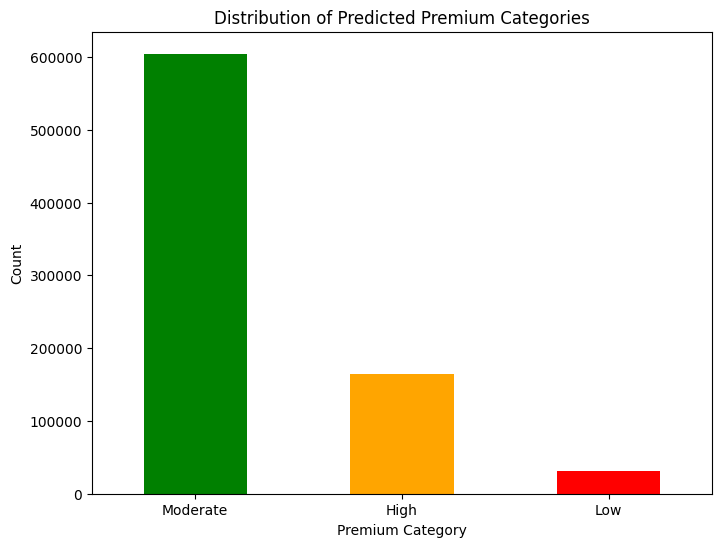

In [24]:
# Adding the predictions to the test dataset
test['Predicted Premium'] = test_predictions

# Mapping predicted premium amounts into categories
bins = [0, 1000, 2000, float('inf')]
labels = ['Low', 'Moderate', 'High']
test['Premium Category'] = pd.cut(test['Predicted Premium'], bins=bins, labels=labels, include_lowest=True)

# Visualizing the distribution of premium categories
category_counts = test['Premium Category'].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Distribution of Predicted Premium Categories')
plt.xlabel('Premium Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()